# Import Libraries

In [25]:
import os
import numpy as np
from PIL import Image

import torch
from torch import nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models

import matplotlib.pyplot as plt

# Initialize Constants

In [26]:
PHOTO_PATH = 'dp_3.jpg' # content image path
ART_PATH = '11.jpg' # style image path

RESIZE_DIM = (800, 600)
ALPHA = 1
BETA = 1000000

STYLE_LAYERS = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
CONTENT_LAYER = 'conv4_2'

CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda") if CUDA else torch.device("cpu")

EPOCHS = 2000

In [27]:
STYLE_WEIGHTS = {
    'conv1_1' : 1,
    'conv2_1' : 1,
    'conv3_1' : 0.2,
    'conv4_1' : 0.2,
    'conv5_1' : 0.2
}

INDEX_TO_LAYER_MAPPING = {
    0: 'conv1_1',
    5: 'conv2_1',
    10: 'conv3_1',
    19: 'conv4_1',
    28: 'conv5_1',
    21: 'conv4_2',
}

# Helper Functions

### Load content and style images

In [28]:
def load_images(photo_path=PHOTO_PATH, art_path=ART_PATH, resize_dim=RESIZE_DIM):
  p_img = np.array(Image.open(photo_path).resize(resize_dim))[:, :, :3]
  a_img = np.array(Image.open(art_path).resize(resize_dim))[:, :, :3]

  transformations = transforms.Compose([
                                          transforms.ToPILImage(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                        ])
  return transformations(p_img).unsqueeze(0).to(DEVICE), transformations(a_img).unsqueeze(0).to(DEVICE)

### Normalize image to range [0, 1] 

In [29]:
def scale_image(image):
  scaled_img = (((image - image.min()) * (1/(image.max() - image.min()))) * 255).astype('uint8')
  # scaled_img = ((image - image.min()) * (1/(image.max() - image.min()))) 
  return scaled_img

### Visualize and save image

In [30]:
def convert_img(img):
  img = img.squeeze()
  img = img.permute(1, 2, 0).cpu().detach().numpy()
  return scale_image(img)

In [31]:
def visualize_tensor_images(image_1, image_2, image_3, figsize=(10, 5)):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)

  ax1.imshow(convert_img(image_1))
  ax2.imshow(convert_img(image_2))
  ax3.imshow(convert_img(image_3))

  ax1.axis('off')
  ax2.axis('off')
  ax3.axis('off')
  plt.show()

In [32]:
def save_image(img, name='my_image.png'):
  if not os.path.exists("My Images"):
    os.makedirs("My Images")

  img = convert_img(img)
  img = Image.fromarray(img)
  
  img.save(os.path.join("My Images", name))
  print('Image saved successfully !')

### Extract content and style feature maps from intermediate layers

In [33]:
def extract_features(inp, model_features, index_to_layer_mappings=INDEX_TO_LAYER_MAPPING):

  feature_dict = {}
  num_of_layers = len(model_features)
  
  for index in range(num_of_layers):
    inp = model_features[index](inp)

    if index in index_to_layer_mappings:
      feature_dict[index_to_layer_mappings[index]] = inp

  return feature_dict

### Compute Gram matrices from style feature maps

In [34]:
def compute_gram_matrix(features):
  _, c, w, h = features.size()
  matrix = torch.reshape(features, (c, w*h))
  gm = torch.mm(matrix, matrix.t())
  return gm

In [35]:
def get_style_gram_matrices(feature_dict, layer_names=STYLE_LAYERS):
  gram_matrices = {}

  for name in layer_names:
    gram_matrices[name] = compute_gram_matrix(feature_dict[name])

  return gram_matrices

### Compute style loss

In [36]:
def compute_style_loss(art_image_feature_dict, target_image_feature_dict, art_gram_matrices, style_weights=STYLE_WEIGHTS, layer_names=STYLE_LAYERS):

  target_gram_matrices = get_style_gram_matrices(target_image_feature_dict)
  weighted_style_loss = 0

  for name in layer_names:
    _, c, w, h = art_image_feature_dict[name].size()
    a = art_gram_matrices[name]
    t = target_gram_matrices[name]

    layer_loss = torch.mean(torch.square(a - t)) / (c * h * w)
    weighted_style_loss += style_weights[name] * layer_loss 


  return weighted_style_loss

### Compute content loss

In [37]:
def compute_content_loss(photo_image_feature_dict, target_image_feature_dict, layer_name=CONTENT_LAYER):
  loss = torch.mean(torch.square(photo_image_feature_dict[layer_name] - target_image_feature_dict[layer_name]))
  return loss

# Training

In [39]:
model =  models.vgg19(pretrained=True).to(DEVICE).features
for parameter in model.parameters():
  parameter.requires_grad_(False)

photo, art = load_images(resize_dim=RESIZE_DIM)

target = photo.clone().requires_grad_(True).to(DEVICE) #torch.randn(1, 3, RESIZE_DIM[0], RESIZE_DIM[1]).to(DEVICE)

optimizer = optim.Adam([target], lr=0.01)

photo_image_feature_dict = extract_features(photo, model)
art_image_feature_dict = extract_features(art, model)
target_image_feature_dict = extract_features(target, model)

art_gram_matrices = get_style_gram_matrices(art_image_feature_dict)

In [40]:
for e in range(1, EPOCHS+1):  
  target_image_feature_dict = extract_features(target, model, INDEX_TO_LAYER_MAPPING)
  # art_gram_matrices = get_style_gram_matrices(art_image_feature_dict)

  content_loss = compute_content_loss(photo_image_feature_dict, target_image_feature_dict, CONTENT_LAYER)
  style_loss = compute_style_loss(art_image_feature_dict, target_image_feature_dict, art_gram_matrices, STYLE_WEIGHTS, STYLE_LAYERS)

  total_loss = ALPHA * content_loss + BETA * style_loss

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if e % 100 == 0:
    print('Epoch = {} | content loss = {} | style loss = {}'.format(e, content_loss, style_loss))

Epoch = 100 | content loss = 16.118432998657227 | style loss = 7360.5419921875
Epoch = 200 | content loss = 19.825721740722656 | style loss = 2531.032470703125
Epoch = 300 | content loss = 21.555009841918945 | style loss = 1251.8563232421875
Epoch = 400 | content loss = 22.475440979003906 | style loss = 770.4090576171875
Epoch = 500 | content loss = 23.036195755004883 | style loss = 547.4373779296875
Epoch = 600 | content loss = 23.421730041503906 | style loss = 425.5853271484375
Epoch = 700 | content loss = 23.717498779296875 | style loss = 348.9986267089844
Epoch = 800 | content loss = 23.963603973388672 | style loss = 295.1357727050781
Epoch = 900 | content loss = 24.180662155151367 | style loss = 254.3589324951172
Epoch = 1000 | content loss = 24.363317489624023 | style loss = 221.8603515625
Epoch = 1100 | content loss = 24.531696319580078 | style loss = 195.0647430419922
Epoch = 1200 | content loss = 24.6743106842041 | style loss = 172.57638549804688
Epoch = 1300 | content loss = 

# Visualize Images

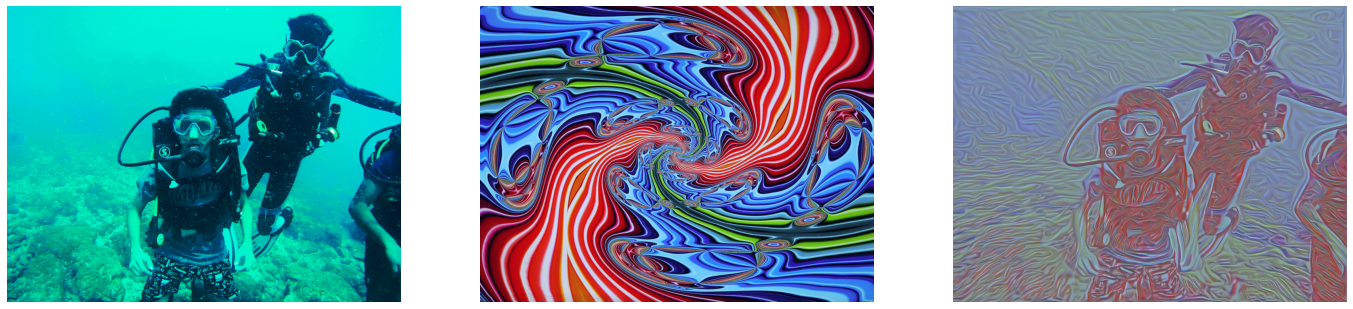

In [41]:
visualize_tensor_images(photo, art, target, figsize=(24, 8))

In [44]:
save_image(target, name='target.png')
# save_image(photo, name='content.png')
# save_image(art, name='style.png')

Image saved successfully !
Image saved successfully !
Image saved successfully !
